# Model Building
This notebooks contains the the model building for the first iteration - including model optimization via gridsearch

# Imports

In [41]:
# Necessary to import custom modules
import os
os.chdir("/home/jovyan/work")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 7)

# Construct data

In [42]:
# read features and drop obsolete ones
df_raw = pd.read_csv("./data/features/first_iteration.csv")

# construct training data
df_train = \
    df_raw[df_raw["season"].isin(["2015/2016", "2016/2017"])]\
    .drop(["team_home", "team_guest", "score_home", "score_guest", "season"]
          + [col for col in df_raw.columns if "2017/2018" in col] , axis=1)
X_train, y_train = df_train.drop(["home_win"], axis=1).values, df_train["home_win"].values

# construct final validation data
df_val = \
    df_raw[df_raw["season"] == "2017/2018"]\
    .drop(["team_home", "team_guest", "score_home", "score_guest", "season"]
          + [col for col in df_raw.columns if "2017/2018" in col] , axis=1)
X_val, y_val = df_val.drop(["home_win"], axis=1).values, df_val["home_win"].values

In [48]:
print("\n\t\t\item ".join([
    c.replace("_", "\_") for c in df_train.columns
]))

home\_win
		\item wins\_as\_home\_2015/2016\_home
		\item wins\_as\_home\_2016/2017\_home
		\item wins\_as\_guest\_2015/2016\_home
		\item wins\_as\_guest\_2016/2017\_home
		\item losses\_as\_home\_2015/2016\_home
		\item losses\_as\_home\_2016/2017\_home
		\item losses\_as\_guest\_2015/2016\_home
		\item losses\_as\_guest\_2016/2017\_home
		\item score\_margin\_as\_home\_2015/2016\_home
		\item score\_margin\_as\_home\_2016/2017\_home
		\item score\_margin\_as\_guest\_2015/2016\_home
		\item score\_margin\_as\_guest\_2016/2017\_home
		\item wins\_as\_home\_2015/2016\_guest
		\item wins\_as\_home\_2016/2017\_guest
		\item wins\_as\_guest\_2015/2016\_guest
		\item wins\_as\_guest\_2016/2017\_guest
		\item losses\_as\_home\_2015/2016\_guest
		\item losses\_as\_home\_2016/2017\_guest
		\item losses\_as\_guest\_2015/2016\_guest
		\item losses\_as\_guest\_2016/2017\_guest
		\item score\_margin\_as\_home\_2015/2016\_guest
		\item score\_margin\_as\_home\_2016/2017\_guest
		\item score\_margi

# Baseline

### Predict always win

In [21]:
log_loss(y_val, np.ones_like(y_val))

14.268635813909114

### Predict always loss

In [22]:
log_loss(y_val, np.zeros_like(y_val))

20.270470902500936

### Predict always draw

In [23]:
log_loss(y_val, np.ones_like(y_val)*.5)

0.69314718055994529

# Logistic Regression

In [24]:
# parameter grid
pg_lr = {
    "penalty": ["l1", "l2"],
    "C": [0.001, 0.01, 0.1, 1.0, 10],
}

# cross validated estimator
GS_LR = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=pg_lr,
    cv=5,
    n_jobs=-1,
    scoring="neg_log_loss"
)

# model fitting
GS_LR.fit(X_train, y_train)

# evaluate on validation set
log_loss(y_val, GS_LR.predict_proba(X_val))

0.68554226942220065

In [25]:
# best estimator
GS_LR.best_estimator_

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [26]:
# misclassified samples
(GS_LR.predict(X_val) != y_val).sum()

516

In [27]:
# misclassified percentage
(GS_LR.predict(X_val) != y_val).sum()/len(y_val)

0.39329268292682928

# Random Forest

In [28]:
# parameter grid
param_grid = {
    "n_estimators": [5, 10, 15, 20],
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "min_samples_split": [2, 3, 4, 5]
}

# cross validated estimator
GS_RF = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    scoring="neg_log_loss"
)

# model fitting
GS_RF.fit(X_train, y_train)

# evaluate on validation set
log_loss(y_val, GS_RF.predict_proba(X_val))

0.82862310206478462

In [29]:
# best estimator
GS_RF.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
# misclassified samples
(GS_RF.predict(X_val) != y_val).sum()

560

In [31]:
# misclassified percentage
(GS_RF.predict(X_val) != y_val).sum()/len(y_val)

0.42682926829268292

# Comparison of wrong predictions

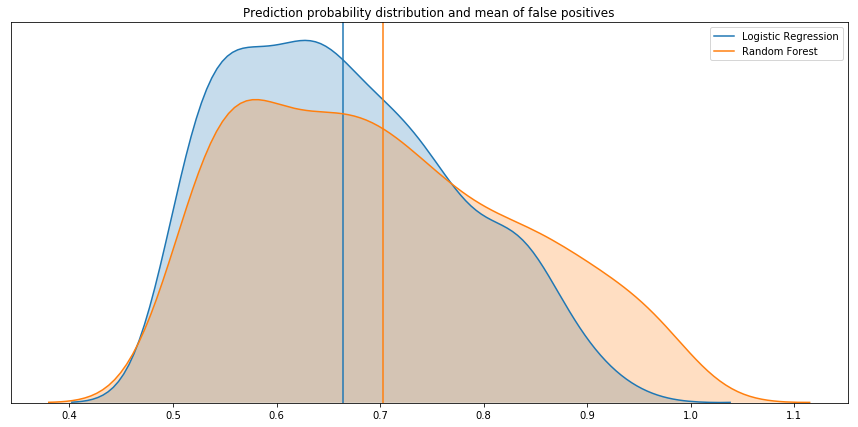

In [32]:
# LR
idx_wrong_lr = GS_LR.predict(X_val) != y_val
y_wrong_lr = []
for preds in GS_LR.predict_proba(X_val)[idx_wrong_lr]:
    y_wrong_lr.append(preds.max())

# RF
idx_wrong_rf = GS_RF.predict(X_val) != y_val
y_wrong_rf = []
for preds in GS_RF.predict_proba(X_val)[idx_wrong_lr]:
    y_wrong_rf.append(preds.max())

# plot
colors = sns.color_palette(n_colors=2).as_hex()
sns.kdeplot(y_wrong_lr, shade=True, label="Logistic Regression")
plt.axvline(x=np.mean(y_wrong_lr), color=colors[0])
sns.kdeplot(y_wrong_rf, shade=True, clip=[0,1], label="Random Forest")
plt.axvline(x=np.mean(y_wrong_rf), color=colors[1])
plt.title("Prediction probability distribution and mean of false predictions")
plt.yticks([])
plt.savefig("results/1_2_prediction_proba_false_positives.png")

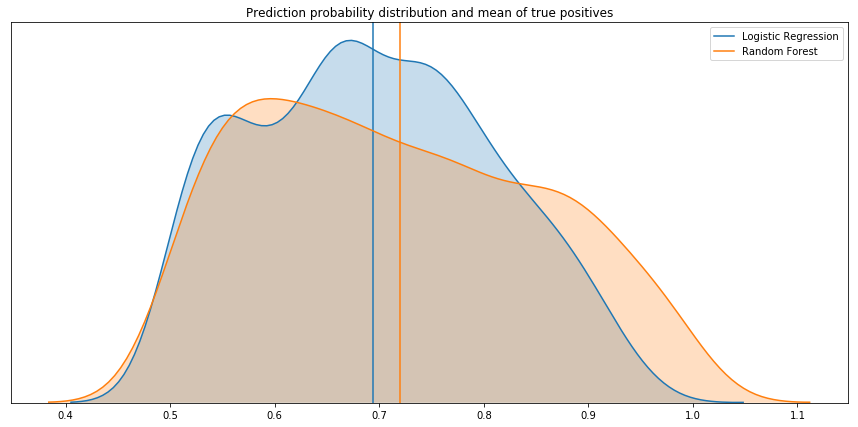

In [53]:
# LR
idx_right_lr = GS_LR.predict(X_val) == y_val
y_right_lr = []
for preds in GS_LR.predict_proba(X_val)[idx_right_lr]:
    y_right_lr.append(preds.max())

# RF
idx_right_rf = GS_RF.predict(X_val) == y_val
y_right_rf = []
for preds in GS_RF.predict_proba(X_val)[idx_right_rf]:
    y_right_rf.append(preds.max())

# plot
colors = sns.color_palette(n_colors=2).as_hex()
sns.kdeplot(y_right_lr, shade=True, label="Logistic Regression")
plt.axvline(x=np.mean(y_right_lr), color=colors[0])
sns.kdeplot(y_right_rf, shade=True, clip=[0,1], label="Random Forest")
plt.axvline(x=np.mean(y_right_rf), color=colors[1])
plt.title("Prediction probability distribution and mean of true positives")
plt.yticks([])
plt.savefig("results/1_2_prediction_proba_true_positives.png")

In [57]:
GS_RF.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)